# Сети Кохонена

**Цель работы:** исследование свойств слоя Кохонена, карты Кохонена, а также сетей векторного квантования, обучаемых с учителем, алгоритмов обучения, а также применение сетей в задачах кластеризации и классификации.


| <!-- --> | <!-- --> |
|:---------|:---------|
| Студент    | Почечура А. А.   |
| Группа   | М8О-406Б-20  |
| Вариант    | 18   |

Подключаем библиотеки, которые нам понадобятся в данной работе

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

Зададим данные о центрах кластеров, отобразим их на графике

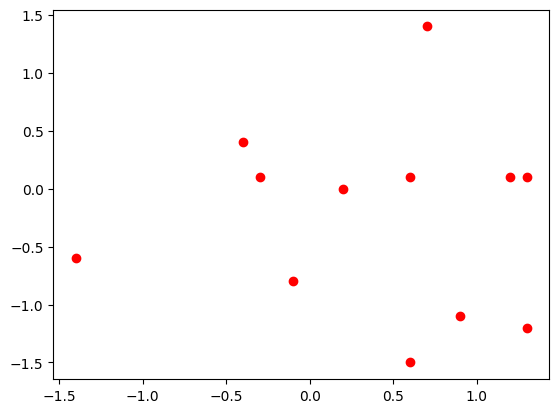

In [2]:
data = np.array([
        [0.6, 0.1],
        [0.7, 1.4],
        [1.3, 0.1],
        [1.3, -1.2],
        [-1.4, -0.6],
        [0.2, 0],
        [1.2, 0.1],
        [-0.3, 0.1],
        [0.6, -1.5],
        [0.9, -1.1],
        [-0.1, -0.8],
        [-0.4, 0.4],
])

plt.scatter(data[:,0],data[:,1],color='r')

Сгенерируем для каждого кластера 10 случайных точек. Покрасим их в цвета, которые будут обозначать отношение точки к конкретному кластеру. Отобразим данные на графике.

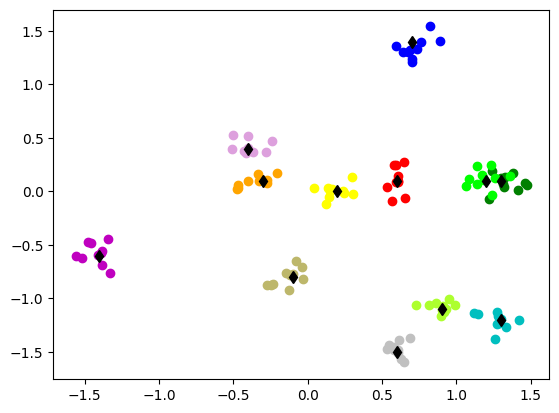

In [5]:
def make_blobs(data, number, rad):
  n = number
  res = np.ones((data.shape[0]*number, 2))
  ans = np.ones((data.shape[0]*number))
  for i in range (data.shape[0]):
    for j in range (number):
      a = random.uniform(0, 2*np.pi)
      r = random.uniform(0, rad)
      res[n*i+j,0] = data[i,0]+r*np.cos(a)
      res[n*i+j,1] = data[i,1]+r*np.sin(a)
      ans[n*i+j] = i
  return res, ans



n = data.shape[0]
clrs = ['r', 'b', 'g', 'c', 'm', 'yellow', 'lime', 'orange', 'silver',  'greenyellow', 'darkkhaki', 'plum']
x, y = make_blobs(data, 10, 0.2)
for i in range(n):
  plt.scatter(x[y==i,0],x[y==i,1],color=clrs[i])
plt.plot(data[:,0], data[:, 1], 'dk')

plt.show()

Создадим класс Kohonen, в котором будет описана сеть Кохонена. Изменение весов будет происходить путём нахождения "нейрона-победителя" и смещения его значений на разность между значениями нейрона и входного значения, умноженную на коэффициент *learning rate*.

In [6]:
class Kohonen():
    def __init__(self, inputs, hidden):
        self.weights = np.random.randn(hidden, inputs)
        self.weights[:,0] = self.weights[:,0] / ((self.weights**2).sum(axis=1))**0.5
        self.weights[:,1] = self.weights[:,1] / ((self.weights**2).sum(axis=1))**0.5

    def forward(self, x):
        ind = ((((self.weights - x)**2).sum(axis=1))**0.5).argmin()
        return ind

    def train(self, data, epochs, lr=0.1):
        for epoch in tqdm(range(epochs)):
            for x in data:
                ind = self.forward(x)
                self.weights[ind,:] = self.weights[ind,:] +lr*(x-self.weights[ind,:])

Производим обучение модели. Количество нейронов в сети равно количеству кластеров.

In [7]:
model = Kohonen(2, n)
model.train(x, 1000, 0.1)

100%|██████████| 1000/1000 [00:01<00:00, 653.15it/s]


Отобразим полученные данные на графике

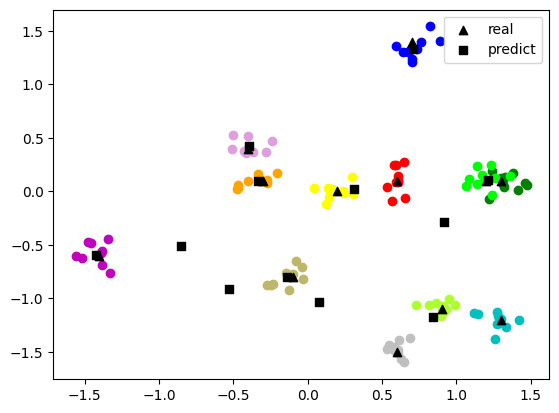

In [8]:
pred = model.weights

for i in range(n):
  plt.scatter(x[y==i,0],x[y==i,1],color=clrs[i])
plt.scatter(data[:,0], data[:, 1], c = 'black', marker='^', label="real")
plt.scatter(pred[:,0], pred[:, 1], c = 'black', marker='s', label="predict")
plt.legend()
plt.show()

Рассмотрим кластеризацию всех точек на промежутке [-1.5, 1.5] x [-1.5, 1.5] и изобразим полученные результаты на графике

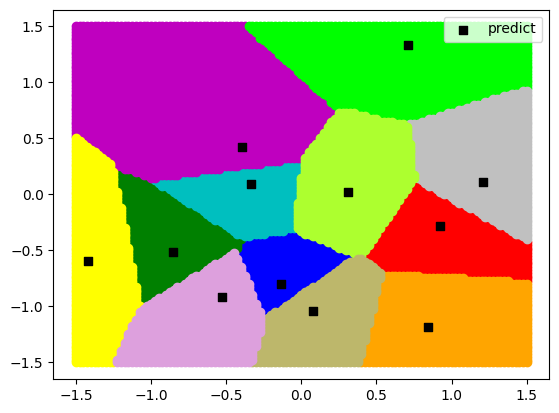

In [9]:
h = 0.025
xx = np.array([i for i in np.arange(-1.5, 1.5 + h, h) for j in np.arange(-1.5, 1.5 + h, h)])
yy = np.array([j for i in np.arange(-1.5, 1.5 + h, h) for j in np.arange(-1.5, 1.5 + h, h)])

predict = np.array([ model.forward(np.array([i,j])) for i in np.arange(-1.5, 1.5 + h, h) for j in np.arange(-1.5, 1.5 + h, h)])

for i in range(n):
  plt.scatter(xx[predict==i],yy[predict==i],color=clrs[i])
plt.scatter(pred[:,0], pred[:, 1], c = 'black', marker='s', label="predict")
plt.legend()
plt.show()

Создадим класс SOM, который будет описывать самоорганизующиеся карты Кохонена. Здесь алгоритм будет в основном такой же, как и в сети Кохонена, только преобразованию будут подвергаться ещё и нейроны, соседние с "нейроном-победителем" (соседство определяется с помощью функции Гаусса).

In [10]:
class SOM():
    def __init__(self, in_features, w, h):
        self.in_features = in_features
        self.w = w
        self.h = h
        self.weights = np.random.randn(w * h, in_features)
        self.weights[:,0] = self.weights[:,0] / ((self.weights**2).sum(axis=1))**0.5
        self.weights[:,1] = self.weights[:,1] / ((self.weights**2).sum(axis=1))**0.5
        self.indices = np.array([[x, y] for x in range(0, h) for y in range(0, w)])

    def update(self, x, rad, lr):
        ind = ((((self.weights - x)**2).sum(axis=1))**0.5).argmin()
        h = (((self.indices - self.indices[ind])**2).sum(axis=1))**0.5

        for w, dist in zip(self.weights, h):
          if(dist < rad):
            w += lr * np.exp(-dist/2./rad) * (x - w)

    def train(self, data, epochs, lr_0=1):
        s_0 = max(self.w, self.h) // 2
        t_1 = epochs / np.log(s_0)
        t_2 = epochs
        for epoch in tqdm(range(epochs)):
            np.random.shuffle(data)
            rad = s_0 * np.exp(-epoch / t_1)
            lr = lr_0 * np.exp(-epoch / t_2)
            if (lr < 0.01):
                lr = 0.01
            for elem in data:
                self.update(elem, rad, lr)

Задаём параметры сети: признаки, по которым будет происходит кластеризация, и размеры нейронной сетки.

In [11]:
model = SOM(in_features=2, w=50, h=50)

Произведём обучение нашей сети.

In [14]:
model.train(data, 150)

100%|██████████| 150/150 [00:05<00:00, 29.98it/s]


Отобразим полученные данные на графике:

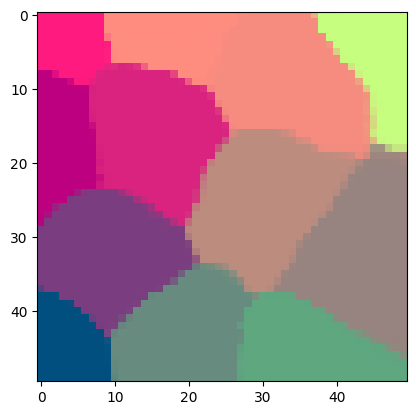

In [15]:
nodes = model.weights

nodes_min = np.min(nodes, axis=0)
nodes_max = np.max(nodes, axis=0)

nodes_scaled = ((nodes - nodes_min) / (nodes_max - nodes_min)).reshape((model.h, model.w, model.in_features))

plt.imshow(np.insert(nodes_scaled, 2, 0.5, axis = 2))
plt.show()

**Вывод:** В процессе выполнения данной лабораторной работы я научился самостоятельно реализовывать и практически применять нейронную сеть Кохонена. Интересно было разбираться в тонкостях реализации данной сети. Рассмотренная сеть имеет одну главную особенность - обучение происходит без "учителя". Такой подход позволяет очень хорошо справляться с задачей кластеризации.